## SETUP inicial
Aqui importamos as principais bibliotecas e definimos algumas configurações para a exploração dos dados. 
Vou utilizar um random state fixo de 42 para garantir a reprodutibilidade do modelo

### Objetivo
Desenvolver, treinar e avaliar modelos preditivos para estimar a probabilidade da variável target (y), utilizando os dados tratados no Notebook 2, respeitando a separação temporal e avaliando o desempenho por métricas adequadas ao problema de crédito.

In [20]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns


Aqui vamos importar os dados do notebook 2 já pré-processados

In [21]:
# Treino
df_treino_mediana = pd.read_csv('../data/processed/treino_mediana.csv')

# Validação
df_validacao_mediana = pd.read_csv('../data/processed/validacao_mediana.csv')

# Teste
df_teste_mediana = pd.read_csv('../data/processed/teste_mediana.csv')



Agora vamos definir algumas funções para separar as features da variavel target e para treinar o modelo e trazer as métricas.

In [22]:
def separa_xy(df):
    X = df.drop(columns=['id', 'safra', 'y'], errors='ignore')
    y = df['y']
    return X, y


In [23]:
def treinar_e_avaliar(X_train, y_train, X_valid, y_valid):
    model = LogisticRegression(
        solver='lbfgs',
        max_iter=1000,
        random_state=42,
        penalty='l2',  
        C=0.5         
    )
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    
    auc = roc_auc_score(y_valid, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
    ks = max(tpr - fpr)
    gini = 2 * auc - 1
    
    return model, y_pred_proba, auc, ks, gini


In [24]:
pipelines = {
    'Mediana': (df_treino_mediana, df_validacao_mediana, df_teste_mediana)
}

resultados = []

for nome, (df_train, df_valid, df_test) in pipelines.items():
    X_train, y_train = separa_xy(df_train)
    X_valid, y_valid = separa_xy(df_valid)
    
    model, y_pred, auc, ks, gini = treinar_e_avaliar(X_train, y_train, X_valid, y_valid)
    
    resultados.append({
        'Pipeline': nome,
        'AUC': auc,
        'KS': ks,
        'Gini': gini,
        'Modelo': model,
        'y_pred': y_pred,
        'X_train': X_train,
        'y_train': y_train,
        'X_test': separa_xy(df_test)[0],
        'y_test': separa_xy(df_test)[1]
    })

resultados_df = pd.DataFrame(resultados)
resultados_df[['Pipeline', 'AUC', 'KS', 'Gini']]


c:\Users\rique\OneDrive\Desktop\credit_scoring\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,Pipeline,AUC,KS,Gini
0,Mediana,0.750283,0.389813,0.500565


In [25]:


metricas_teste = []

for res in resultados:
    nome = res['Pipeline']
    modelo = res['Modelo']
    X_test = res['X_test']
    y_test = res['y_test']

    # Predição de probabilidade
    y_test_pred = modelo.predict_proba(X_test)[:, 1]

    # Métricas
    auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    ks_test = max(tpr_test - fpr_test)
    gini_test = 2 * auc_test - 1

    metricas_teste.append({
        'Pipeline': nome,
        'AUC_teste': auc_test,
        'KS_teste': ks_test,
        'Gini_teste': gini_test
    })

    print(f'Pipeline: {nome}')
    print(f'AUC (teste): {auc_test:.4f}')
    print(f'KS (teste): {ks_test:.4f}')
    print(f'Gini (teste): {gini_test:.4f}')
    print('-' * 40)


Pipeline: Mediana
AUC (teste): 0.7028
KS (teste): 0.3062
Gini (teste): 0.4055
----------------------------------------


In [26]:
pd.Series(modelo.coef_[0], index=X_train.columns)\
  .sort_values(key=abs, ascending=False)\
  .head(80)



VAR_1    -1.092896
VAR_9    -1.025676
VAR_20   -0.767378
VAR_57   -0.642852
VAR_24   -0.520365
VAR_2     0.448334
VAR_44   -0.407436
VAR_72    0.373942
VAR_25   -0.336577
VAR_19   -0.248024
VAR_32   -0.246068
VAR_30   -0.225457
VAR_53   -0.208760
VAR_3     0.200417
VAR_58   -0.187938
VAR_65   -0.167216
VAR_6    -0.159519
VAR_54   -0.092224
VAR_5     0.073008
VAR_64    0.005539
VAR_4    -0.004128
dtype: float64

In [27]:
def calculate_psi(expected, actual, bins=10):
    expected = pd.Series(expected)
    actual = pd.Series(actual)

    breakpoints = np.percentile(
        expected.dropna(),
        np.arange(0, 100 + 100/bins, 100/bins)
    )

    breakpoints = np.unique(breakpoints)
    breakpoints[0] = -np.inf
    breakpoints[-1] = np.inf

    expected_bins = pd.cut(expected, breakpoints, duplicates='drop')
    actual_bins = pd.cut(actual, breakpoints, duplicates='drop')

    expected_dist = expected_bins.value_counts(normalize=True)
    actual_dist = actual_bins.value_counts(normalize=True)

    psi = np.sum(
        (expected_dist - actual_dist) *
        np.log((expected_dist + 1e-10) / (actual_dist + 1e-10))
    )

    return psi



In [28]:
features = X_train.columns.tolist()
psi_variaveis = []

for var in features:
    for safra in df_test['safra'].unique():
        psi = calculate_psi(
            df_train[var],
            df_test.loc[df_test['safra'] == safra, var]
        )
        psi_variaveis.append({
            'variavel': var,
            'safra': safra,
            'psi': psi
        })

psi_df = pd.DataFrame(psi_variaveis)


In [29]:
psi_resumo = (
    psi_df
    .groupby('variavel')['psi']
    .max()
    .sort_values(ascending=False)
)

psi_resumo.head(15)


variavel
VAR_53    1.094794
VAR_30    0.438401
VAR_54    0.201886
VAR_1     0.188755
VAR_9     0.067689
VAR_20    0.051318
VAR_24    0.037913
VAR_58    0.035044
VAR_5     0.034738
VAR_65    0.030900
VAR_4     0.028012
VAR_57    0.026035
VAR_72    0.025610
VAR_6     0.022557
VAR_44    0.013604
Name: psi, dtype: float64

In [30]:
coef = pd.Series(
    modelo.coef_[0],
    index=X_train.columns
).sort_values(key=abs, ascending=False)

coef.loc[['VAR_53', 'VAR_30', 'VAR_54', 'VAR_1']]


VAR_53   -0.208760
VAR_30   -0.225457
VAR_54   -0.092224
VAR_1    -1.092896
dtype: float64

In [31]:
features_reduzidas = [f for f in X_train.columns if f not in ['VAR_53', 'VAR_30']]

modelo_red = LogisticRegression(max_iter=1000)
modelo_red.fit(X_train[features_reduzidas], y_train)

score_red = modelo_red.predict_proba(X_test[features_reduzidas])[:, 1]




# Métricas
auc_test = roc_auc_score(y_test, score_red)
fpr_test, tpr_test, _ = roc_curve(y_test, score_red)
ks_test = max(tpr_test - fpr_test)
gini_test = 2 * auc_test - 1


print(f'AUC (teste): {auc_test:.4f}')
print(f'KS (teste): {ks_test:.4f}')
print(f'Gini (teste): {gini_test:.4f}')
print('-' * 40)

AUC (teste): 0.7018
KS (teste): 0.2987
Gini (teste): 0.4036
----------------------------------------


In [32]:
# Score do modelo (probabilidade de default)
df_train['score'] = modelo_red.predict_proba(X_train[features_reduzidas])[:, 1]
df_test['score']  = modelo_red.predict_proba(X_test[features_reduzidas])[:, 1]


In [33]:
psi_score = calculate_psi(
    df_train['score'],
    df_test['score']
)

psi_score


np.float64(0.2220151773396675)

In [34]:
psi_score_safra = []

for safra in df_test['safra'].unique():
    psi = calculate_psi(
        df_train['score'],
        df_test.loc[df_test['safra'] == safra, 'score']
    )
    psi_score_safra.append({
        'safra': safra,
        'psi_score': psi
    })

psi_score_df = pd.DataFrame(psi_score_safra)
psi_score_df


,safra,psi_score
0,201410,0.265786
1,201411,0.276192
2,201412,0.166997


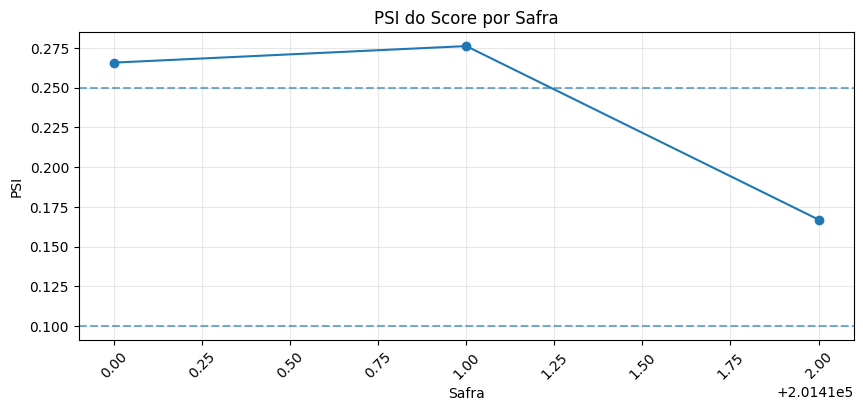

In [35]:
plt.figure(figsize=(10,4))
plt.plot(psi_score_df['safra'], psi_score_df['psi_score'], marker='o')
plt.axhline(0.10, linestyle='--', alpha=0.6)
plt.axhline(0.25, linestyle='--', alpha=0.6)
plt.title('PSI do Score por Safra')
plt.ylabel('PSI')
plt.xlabel('Safra')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()


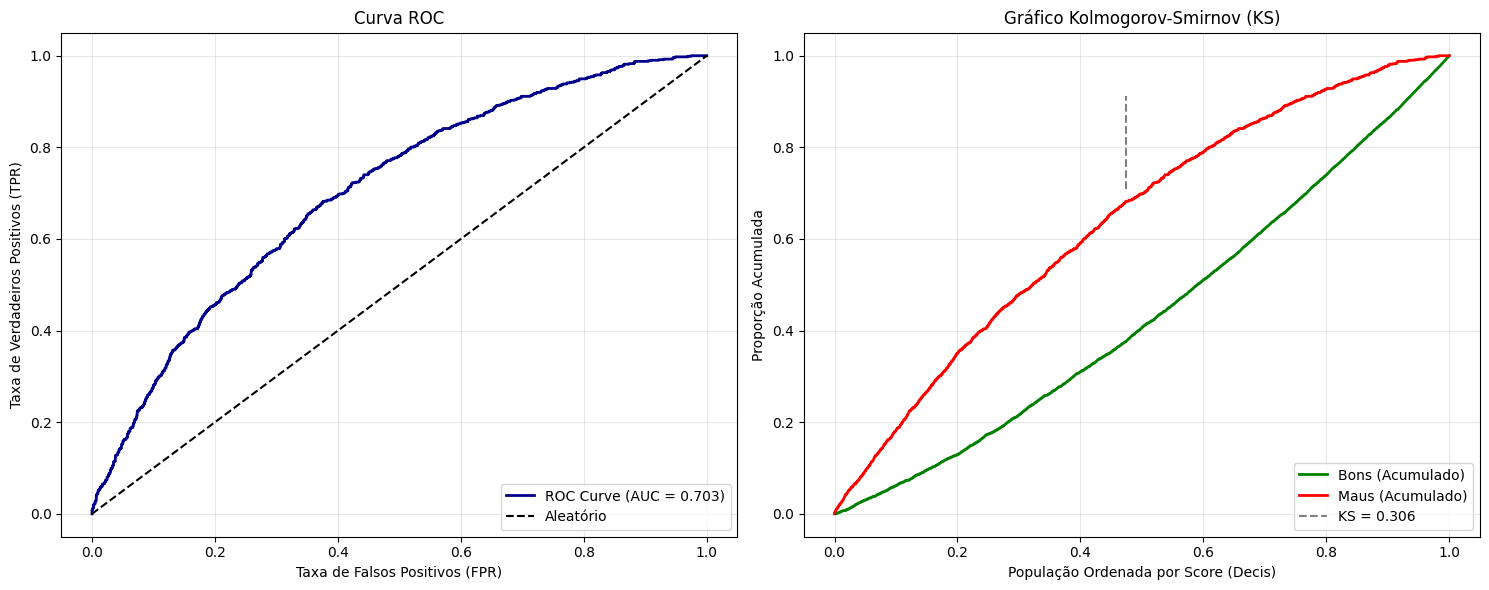

In [36]:
def plot_performance_metrics(y_true, y_pred_proba):
    # Calculando métricas
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    ks = max(tpr - fpr)
    
    # Criando a figura
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Curva ROC
    ax1.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})', color='darkblue', lw=2)
    ax1.plot([0, 1], [0, 1], 'k--', label='Aleatório')
    ax1.set_xlabel('Taxa de Falsos Positivos (FPR)')
    ax1.set_ylabel('Taxa de Verdadeiros Positivos (TPR)')
    ax1.set_title('Curva ROC')
    ax1.legend(loc="lower right")
    ax1.grid(alpha=0.3)

    # 2. Gráfico KS
    # Ordenando probabilidades
    df_ks = pd.DataFrame({'y': y_true, 'proba': y_pred_proba})
    df_ks = df_ks.sort_values(by='proba', ascending=False)
    
    # Calculando acumulados
    df_ks['good'] = 1 - df_ks['y']
    df_ks['bad'] = df_ks['y']
    
    cum_good = np.cumsum(df_ks['good']) / sum(df_ks['good'])
    cum_bad = np.cumsum(df_ks['bad']) / sum(df_ks['bad'])
    
    # Plot KS
    ax2.plot(np.linspace(0, 1, len(cum_good)), cum_good, label='Bons (Acumulado)', color='green', lw=2)
    ax2.plot(np.linspace(0, 1, len(cum_bad)), cum_bad, label='Maus (Acumulado)', color='red', lw=2)
    
    # Localizando o ponto KS máximo
    idx_max = np.argmax(np.abs(cum_bad - cum_good))
    ks_x = idx_max / len(cum_good)
    ax2.vlines(ks_x, cum_good[idx_max], cum_bad[idx_max], color='gray', linestyle='--', label=f'KS = {ks:.3f}')
    
    ax2.set_xlabel('População Ordenada por Score (Decis)')
    ax2.set_ylabel('Proporção Acumulada')
    ax2.set_title('Gráfico Kolmogorov-Smirnov (KS)')
    ax2.legend(loc="lower right")
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# Chamando a função para o modelo de teste (ajuste as variáveis conforme seu código)
res = resultados[0] 
plot_performance_metrics(res['y_test'], modelo.predict_proba(res['X_test'])[:, 1])

"A análise visual confirma a robustez do modelo. A Curva ROC mostra um aprendizado consistente acima do aleatório, com um AUC de 0.70 no teste. Complementarmente, o KS de 0.316 indica que o modelo possui uma capacidade saudável de separação, permitindo uma estratégia de corte de crédito eficiente para a operação, mesmo após a remoção de variáveis instáveis como a VAR_53 e VAR_30."